Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration copy/Train")
data_dir_test = pathlib.Path("/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration copy/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory= data_dir_train,
    label_mode="int",
    batch_size=32,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="training"
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory= data_dir_train,
    label_mode="int",
    batch_size=32,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="validation"
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

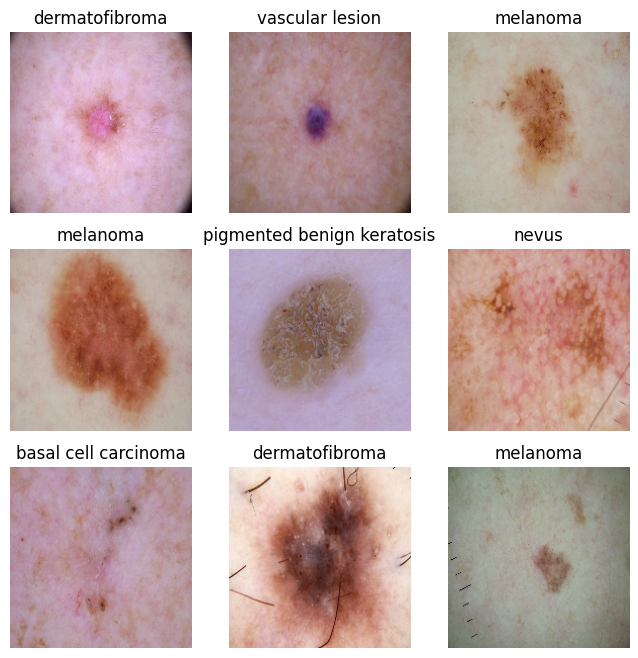

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i].numpy()]) # Convert labels to NumPy array
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

Create CNN structure of 2 X 2D convolution(32,64) layer with kernel size 3X3 , activation funtion Relu(output '0' for -ve and same as input for +ve ),Dense(512), 50% dropout(controls over fitting) and soft max layer (predicts the output probabilities between 0 to 1 )
Use the Regularization strategy early stop, check point to save the computation power and time during trining of model.

In [ ]:
# Defining the parameters
batch_size = 32
num_classes = 9
epochs = 20

#CNN Model Architecture
#Sequential allows you to create models layer-by-layer
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
#First Convulation layer
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(img_height, img_width, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Second Convulation layer
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(Flatten())
#Dense Layer
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
#Dropout layer with 50% Fraction of the input units to drop.
model.add(Dropout(0.5))
#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(Dense(units=num_classes, activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#Apply early stopping to prevent overfitting and reduce training time.
#Use model checkpoints to save the best model during training.
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 90, 90, 64)        0         
                                                        

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 5.6156 - accuracy: 0.2015
Epoch 1: val_loss improved from inf to 2.65728, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/56 [==============================] - 227s 1s/step - loss: 5.6156 - accuracy: 0.2015 - val_loss: 2.6573 - val_accuracy: 0.3177
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 2.2422 - accuracy: 0.3242
Epoch 2: val_loss improved from 2.65728 to 1.96008, saving model to best_model.h5
56/56 [==============================] - 9s 169ms/step - loss: 2.2422 - accuracy: 0.3242 - val_loss: 1.9601 - val_accuracy: 0.3960
Epoch 3/20
55/56 [============================>.] - ETA: 0s - loss: 1.9666 - accuracy: 0.3426
Epoch 3: val_loss improved from 1.96008 to 1.81149, saving model to best_model.h5
56/56 [==============================] - 6s 100ms/step - loss: 1.9664 - accuracy: 0.3410 - val_loss: 1.8115 - val_accuracy: 0.4251
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 1.8676 - accuracy: 0.3929
Epoch 4: val_loss did not improve from 1.81149
56/56 [==============================] - 3s 52ms/step - loss: 1.8676 - accuracy: 0.3929 - val_loss: 1.8733 - val_ac

### Visualizing training results

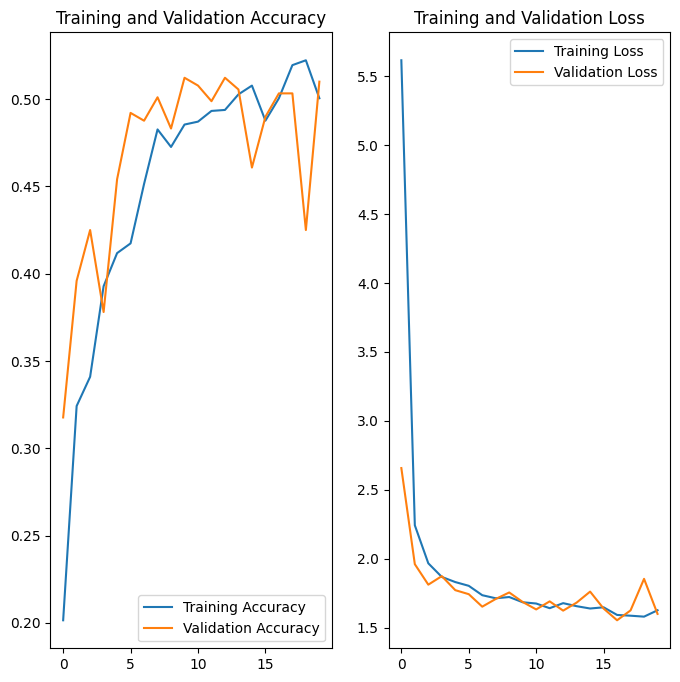

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)


14/14 [==============================] - 0s 12ms/step - loss: 1.5994 - accuracy: 0.5101


After visuvalizing, the training , validation accuracy is very low 50% which indicates model not able to learn from the input data so we can infer that the model is underfitting.

### Todo:
### Create the model, compile and train the model


Using ImageDataGenerator augment strategy Create CNN structure of 2 X 2D convolution(32,64) layer with kernel size 3X3 , activation funtion Relu(output '0' for -ve and same as input for +ve ),Dense(512), 50% dropout(controls over fitting) and soft max layer (predicts the output probabilities between 0 to 1 )

Use the Regularization strategy early stop, check point to save the computation power and time during trining of model.

In [ ]:
# Your code goes here
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
  )




In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
# Define the path to your dataset directory


# Create an iterator for the dataset
train_generator = datagen.flow_from_directory(
    data_dir_train,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    seed=123,
    )
val_generator = datagen.flow_from_directory(
    data_dir_test,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    seed=123,
)
# Get the class indices
class_indices = train_generator.class_indices

# Print class names
class_names = list(class_indices.keys())
print("Class names:", class_names)


Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.
Class names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# New Section

In [ ]:
# Your code goes here
batch_size = 32
num_classes = 9
epochs = 20

#CNN Model Architecture
#Sequential allows you to create models layer-by-layer
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
#First Convulation layer
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(img_height, img_width, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Second Convulation layer
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(Flatten())
#Dense Layer
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
#Dropout layer with 50% Fraction of the input units to drop.
model.add(Dropout(0.5))
#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(Dense(units=num_classes, activation='softmax'))
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 activation_3 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 activation_4 (Activation)   (None, 90, 90, 64)        0         
                                                      

### Compiling the model

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#Apply early stopping to prevent overfitting and reduce training time.
#Use model checkpoints to save the best model during training.
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
history = epochs = 20
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
70/70 [==============================] - ETA: 0s - loss: 6.9811 - accuracy: 0.1894
Epoch 1: val_loss improved from inf to 3.23019, saving model to best_model.h5
70/70 [==============================] - 113s 2s/step - loss: 6.9811 - accuracy: 0.1894 - val_loss: 3.2302 - val_accuracy: 0.1525
Epoch 2/20
70/70 [==============================] - ETA: 0s - loss: 2.4715 - accuracy: 0.2617
Epoch 2: val_loss improved from 3.23019 to 2.48460, saving model to best_model.h5
70/70 [==============================] - 59s 850ms/step - loss: 2.4715 - accuracy: 0.2617 - val_loss: 2.4846 - val_accuracy: 0.2034
Epoch 3/20
70/70 [==============================] - ETA: 0s - loss: 2.0559 - accuracy: 0.3162
Epoch 3: val_loss improved from 2.48460 to 2.35134, saving model to best_model.h5
70/70 [==============================] - 66s 938ms/step - loss: 2.0559 - accuracy: 0.3162 - val_loss: 2.3513 - val_accuracy: 0.2203
Epoch 4/20
70/70 [==============================] - ETA: 0s - loss: 1.8964 - accur

### Visualizing the results

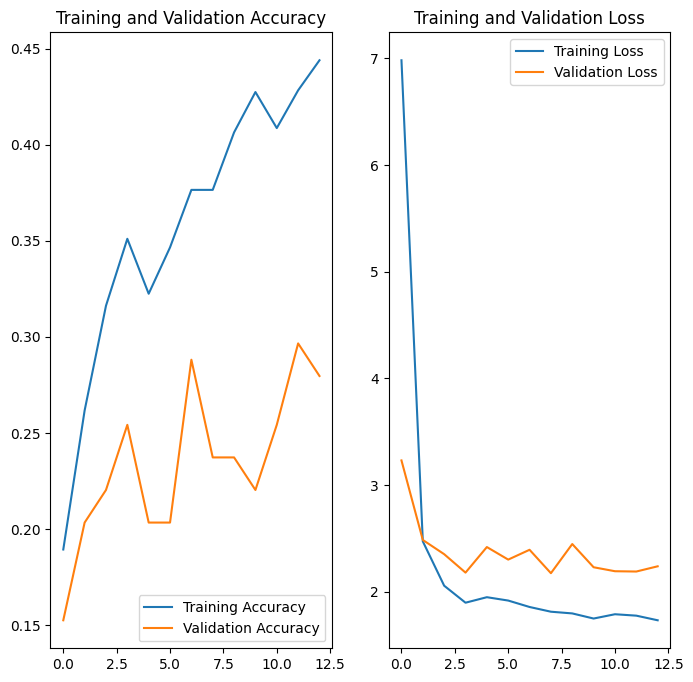

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(epochs)
epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(train_generator, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_generator, verbose=1)


4/4 [==============================] - 6s 1s/step - loss: 2.3146 - accuracy: 0.2542


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

After visuvalizing, the training , validation accuracy is not improved from previous model .

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

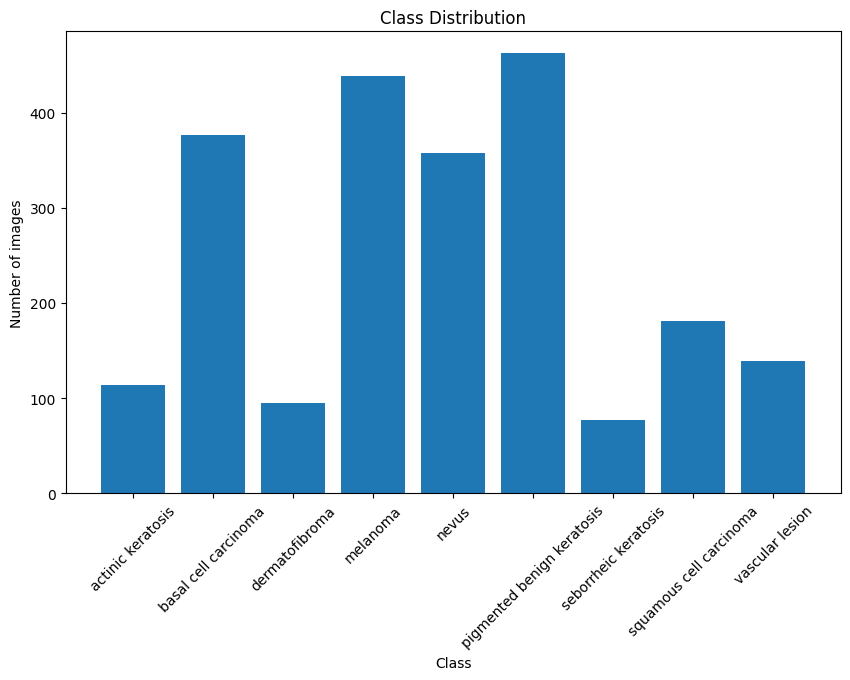

In [ ]:
## Your code goes here.
# Get the class indices and counts
class_indices = train_generator.class_indices
class_counts = train_generator.classes
class_names = list(class_indices.keys())
class_distribution = {class_name: list(class_counts).count(idx) for class_name, idx in class_indices.items()}

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [ ]:
print (class_distribution)

{'actinic keratosis': 114, 'basal cell carcinoma': 376, 'dermatofibroma': 95, 'melanoma': 438, 'nevus': 357, 'pigmented benign keratosis': 462, 'seborrheic keratosis': 77, 'squamous cell carcinoma': 181, 'vascular lesion': 139}


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
'seborrheic keratosis' has minimum no of samples - 77
#### - Which classes dominate the data in terms proportionate number of samples?
'pigmented benign keratosis' has maximum no of samples - 462

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset= str(data_dir_train) #'/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+"/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration copy/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E7B004ABB20>: 100%|██████████| 500/500 [00:19<00:00, 26.27 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration copy/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E7B004EBD00>: 100%|██████████| 500/500 [00:18<00:00, 27.34 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration copy/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E7B004C5210>: 100%|██████████| 500/500 [00:18<00:00, 26.73 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration copy/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E7B009B05B0>: 100%|██████████| 500/500 [01:30<00:00,  5.51 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration copy/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7E7B009B3EE0>: 100%|██████████| 500/500 [01:14<00:00,  6.70 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration copy/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E7B00637460>: 100%|██████████| 500/500 [00:19<00:00, 25.22 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration copy/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E7B009B28F0>: 100%|██████████| 500/500 [00:41<00:00, 12.18 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration copy/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E7B00B9E320>: 100%|██████████| 500/500 [00:19<00:00, 26.28 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration copy/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E7B00696320>: 100%|██████████| 500/500 [00:19<00:00, 26.14 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
import glob

path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [ ]:
new_df['Label'].value_counts()

Label
dermatofibroma                500
melanoma                      500
seborrheic keratosis          500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
pigmented benign keratosis    500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Add third layer 2D-conv(128) with 25% dropout dencelayer CNN structure to increace the image extraction by the way reduce underfitting of model
Use the Regularization strategy early stop, check point to save the computation power and time during trining of model.

In [ ]:
#CNN Model Architecture
#Sequential allows you to create models layer-by-layer
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
#First Convulation layer
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(img_height, img_width, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Second Convulation layer
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Third Convulation layer
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(Flatten())
#Dense Layer
model.add(Dense(128))
model.add(Activation('relu'))
#Dropout layer with 25% Fraction of the input units to drop
model.add(Dropout(0.25))
#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(Dense(units=len(class_names), activation='softmax'))


In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 90, 90, 64)        0         
                                                        

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## Your code goes here
#optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer= 'adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#Apply early stopping to prevent overfitting and reduce training time.
#Use model checkpoints to save the best model during training.
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

#### **Todo:**  Train your model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
169/169 [==============================] - ETA: 0s - loss: 1.8478 - accuracy: 0.3086
Epoch 1: val_loss improved from inf to 1.58301, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


169/169 [==============================] - 1053s 6s/step - loss: 1.8478 - accuracy: 0.3086 - val_loss: 1.5830 - val_accuracy: 0.4232
Epoch 2/20
169/169 [==============================] - ETA: 0s - loss: 1.5310 - accuracy: 0.4082
Epoch 2: val_loss improved from 1.58301 to 1.35968, saving model to best_model.h5
169/169 [==============================] - 497s 3s/step - loss: 1.5310 - accuracy: 0.4082 - val_loss: 1.3597 - val_accuracy: 0.4996
Epoch 3/20
169/169 [==============================] - ETA: 0s - loss: 1.3575 - accuracy: 0.4928
Epoch 3: val_loss improved from 1.35968 to 1.33920, saving model to best_model.h5
169/169 [==============================] - 490s 3s/step - loss: 1.3575 - accuracy: 0.4928 - val_loss: 1.3392 - val_accuracy: 0.4959
Epoch 4/20
169/169 [==============================] - ETA: 0s - loss: 1.2000 - accuracy: 0.5408
Epoch 4: val_loss improved from 1.33920 to 1.14121, saving model to best_model.h5
169/169 [==============================] - 497s 3s/step - loss: 1.200

#### **Todo:**  Visualize the model results

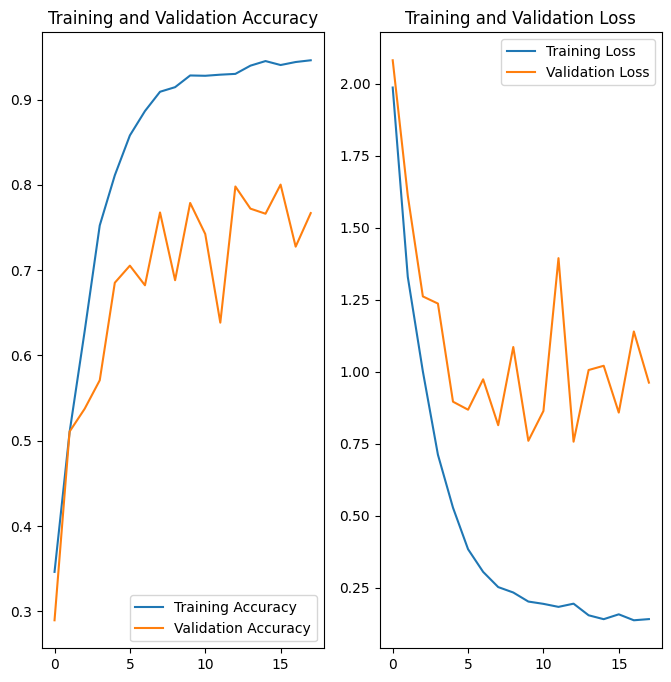

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(epochs)
epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After class balencing the model trining accuracy is improved significantly 90% but validation accuracy is 79% shows model is over fitted.

Add Batch normalisation to input layer and 25% dropout layer to third 2D conv layer to CNN structure to reduce over fitting of model
Use the Regularization strategy early stop, check point to save the computation power and time during trining of model.

In [ ]:
#CNN Model Architecture
#Sequential allows you to create models layer-by-layer
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
#First Convulation layer
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(img_height, img_width, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Second Convulation layer
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Third Convulation layer
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Dropout layer with 25% Fraction of the input units to drop
model.add(Dropout(0.25))
#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(Flatten())
#Dense Layer
model.add(Dense(128))
model.add(Activation('relu'))
#Dropout layer with 25% Fraction of the input units to drop
model.add(Dropout(0.25))
#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(Dense(units=len(class_names), activation='softmax'))


In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_1 (Bat  (None, 180, 180, 32)      128       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)       

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## Your code goes here
#optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer= 'adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#Apply early stopping to prevent overfitting and reduce training time.
#Use model checkpoints to save the best model during training.
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

#### **Todo:**  Train your model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
169/169 [==============================] - ETA: 0s - loss: 1.9330 - accuracy: 0.3186
Epoch 1: val_loss improved from inf to 2.12536, saving model to best_model.h5
169/169 [==============================] - 599s 4s/step - loss: 1.9330 - accuracy: 0.3186 - val_loss: 2.1254 - val_accuracy: 0.1915
Epoch 2/20
169/169 [==============================] - ETA: 0s - loss: 1.3580 - accuracy: 0.4905
Epoch 2: val_loss improved from 2.12536 to 1.82482, saving model to best_model.h5
169/169 [==============================] - 586s 3s/step - loss: 1.3580 - accuracy: 0.4905 - val_loss: 1.8248 - val_accuracy: 0.4150
Epoch 3/20
169/169 [==============================] - ETA: 0s - loss: 1.0750 - accuracy: 0.6066
Epoch 3: val_loss improved from 1.82482 to 1.15923, saving model to best_model.h5
169/169 [==============================] - 583s 3s/step - loss: 1.0750 - accuracy: 0.6066 - val_loss: 1.1592 - val_accuracy: 0.6036
Epoch 4/20
169/169 [==============================] - ETA: 0s - loss: 0.82

#### **Todo:**  Visualize the model results

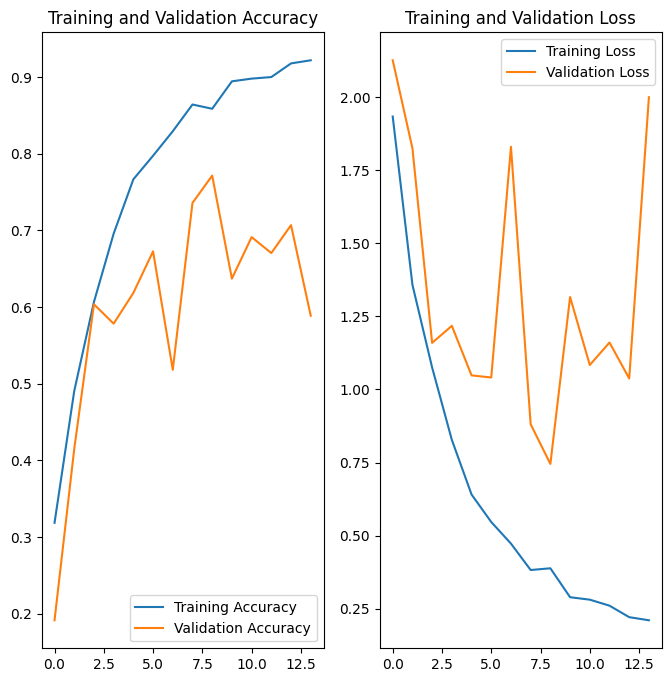

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(epochs)
epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Training accurcy is improved to 92% and validation accurcy reduced shows overfitting of model.

Remove the Batch Normalisation and add third with 50% dropout layer to CNN structure to improve the model performence.
Use the Regularization strategy early stop, check point to save the computation power and time during trining of model.

In [12]:
#CNN Model Architecture
#Sequential allows you to create models layer-by-layer
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
#First Convulation layer
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(img_height, img_width, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Second Convulation layer
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Third Convulation layer
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Dropout layer with 50% Fraction of the input units to drop
model.add(Dropout(0.5))
#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(Flatten())
#Dense Layer
model.add(Dense(128))
model.add(Activation('relu'))
#Dropout layer with 25% Fraction of the input units to drop
model.add(Dropout(0.25))
#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(Dense(units=len(class_names), activation='softmax'))


In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 90, 90, 64)        0         
                                                        

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [14]:
## Your code goes here
#optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer= 'adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#Apply early stopping to prevent overfitting and reduce training time.
#Use model checkpoints to save the best model during training.
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

#### **Todo:**  Train your model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
169/169 [==============================] - ETA: 0s - loss: 2.0236 - accuracy: 0.2326
Epoch 1: val_loss improved from inf to 1.57193, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


169/169 [==============================] - 851s 4s/step - loss: 2.0236 - accuracy: 0.2326 - val_loss: 1.5719 - val_accuracy: 0.4039
Epoch 2/20
169/169 [==============================] - ETA: 0s - loss: 1.5630 - accuracy: 0.4071
Epoch 2: val_loss improved from 1.57193 to 1.43235, saving model to best_model.h5
169/169 [==============================] - 511s 3s/step - loss: 1.5630 - accuracy: 0.4071 - val_loss: 1.4323 - val_accuracy: 0.4625
Epoch 3/20
169/169 [==============================] - ETA: 0s - loss: 1.4415 - accuracy: 0.4512
Epoch 3: val_loss improved from 1.43235 to 1.26253, saving model to best_model.h5
169/169 [==============================] - 504s 3s/step - loss: 1.4415 - accuracy: 0.4512 - val_loss: 1.2625 - val_accuracy: 0.5204
Epoch 4/20
169/169 [==============================] - ETA: 0s - loss: 1.2868 - accuracy: 0.5020
Epoch 4: val_loss improved from 1.26253 to 1.19898, saving model to best_model.h5
169/169 [==============================] - 508s 3s/step - loss: 1.2868

#### **Todo:**  Visualize the model results

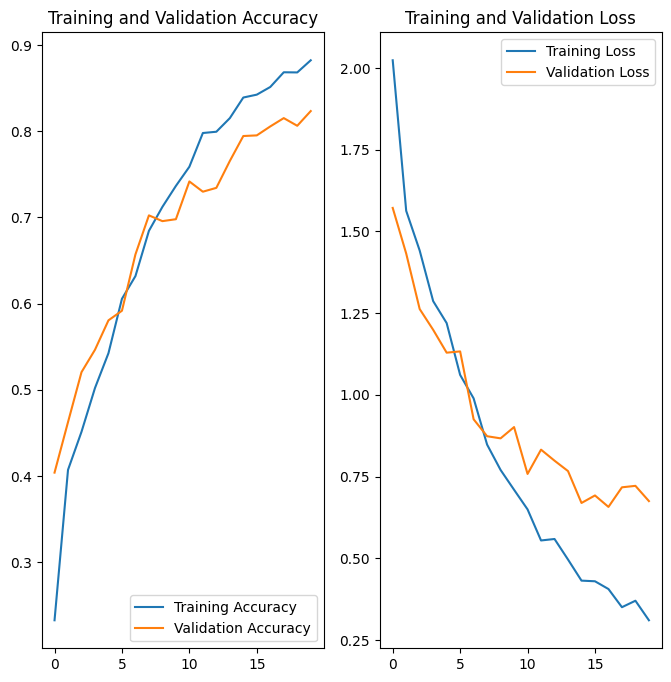

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(epochs)
epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Training accracy is reduced to 86% and validation accuracy improved to 82% shows model overfitting handeled and model performace improved.
- Class balancing helped in handling the underfitting of model
- Dropout strategy helped in reducing the overfitting of model